In [1]:
import torch.nn as nn



class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels, kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  
        return torch.relu(out)


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        self.layer1 = ResidualBlock(64, 128, stride=2)
        self.layer2 = ResidualBlock(128, 256, stride=2)
        self.layer3 = ResidualBlock(256, 512, stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 10)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

In [3]:
import torch
model = CNN()
model.load_state_dict(torch.load("/kaggle/input/cifar10-cnn-residual/pytorch/default/1/cifar10_cnn.pth", weights_only=True))

<All keys matched successfully>

In [68]:
input_image = torch.randn(1, 3, 32, 32).to("cuda")
input_image = input_image.detach().clone()
input_image.requires_grad_(True)
target_class = torch.tensor([9], dtype=torch.long, device="cuda")  # Ensure it's long type

In [69]:
model = model.to("cuda")
model.eval()
for i in range(2000):
    output = model(input_image)
    loss = -torch.nn.functional.cross_entropy(output, target_class)
    
    model.zero_grad()
    loss.backward()
    
    with torch.no_grad():
        input_image += 0.1 * input_image.grad.sign()
        input_image.clamp_(0, 1)
    input_image.grad.zero_()
    if i % 1000 == 0:
        print(f"Iteration {i}, Loss: {loss.item()}")

Iteration 0, Loss: -6.224905967712402
Iteration 1000, Loss: -0.0


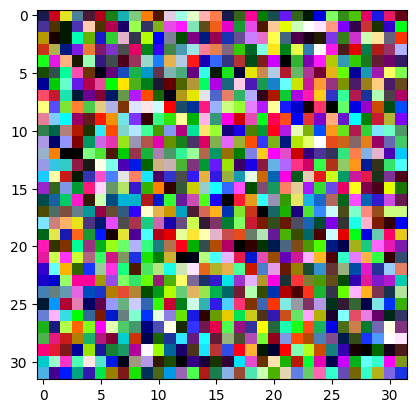

In [71]:
import matplotlib.pyplot as plt
plt.imshow(input_image.to("cpu").detach().numpy().reshape(32, 32, 3))
plt.show()

In [72]:
a = model(input_image)
torch.argmax(torch.nn.functional.softmax(a, dim=1))

tensor(9, device='cuda:0')

In [73]:
import torchvision
train = torchvision.datasets.CIFAR10(root='./data',train=True, download=True)
transform = torchvision.transforms.ToTensor()
a = transform(train[0][0])
print(train[0][1])
a = torch.Tensor(a).to("cuda").unsqueeze(dim=0) + input_image
torch.argmax(torch.nn.functional.softmax(model(a)))

Files already downloaded and verified
6


<ipython-input-73-d9c327f681ba>:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.argmax(torch.nn.functional.softmax(model(a)))


tensor(9, device='cuda:0')